# KOH1: Podstawowa sieć Kohonena
Adrianna Grudzień

-> na 10 maja

## Przebieg eksperymentu i wnioski
- dla neuronów o bardzo zbliżonych wartościach wag istnieje ryzyko, że neurony te będą się pokrywać w toku uczenia - czyli np. mając na wejściu 6 neuronów, na koniec uczenia zostanie ich np. 5, bo dwa z nich będą się pokrywać
- iloczyn skalarny jako metryka odległości jest metryką słabą, zdecydowanie lepsza jest odległość euklidesowa
- jeśli ustawimy za małą wartość parametru `width`, czyli szerokości sąsiedztwa, neurony się na siebie nałożą, więc utracimy klastry

Czy klastry w odwzorowaniu znalezionym przez sieć pokrywają się w liczbą klastrów w faktycznych danych? 
- tak

Czy znalezione klastry pokrywają się z identyfikatorami wierzchołków?
- tak

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Koh:
    def __init__(self, k, N, M, theta_fun='gauss'):
        self.k = k
        self.N = N
        self.M = M
        self.theta_fun = theta_fun
        self.weights = np.random.uniform(-5,5,size=[self.k, self.N*self.M])
        
    
    @staticmethod
    def d(w_array,x_array):
        """Odległość euklidesowa (metryka)"""
        return np.linalg.norm(w_array-x_array)
    @staticmethod
    def distance(n1, n2):
        """Odległość między neuronami"""
        return np.abs(n1[0]-n2[0]) + np.abs(n1[1]-n2[1])
    @staticmethod
    def gauss_fun(x, t):
        """Funkcja Gaussa"""
        return np.exp(-np.square(x))
    @staticmethod
    def mexico_fun(x, t):
        """Meksykański kapelusz (-druga pochodna gauss_fun) przeskalowana do [0,1], czyli (f+1)/3"""
        return (2-4*np.square(x))*np.exp(-np.square(x) + 1) / 3
    def theta(self,n1,n2, t, width):
        """Waga sąsiedztwa wygaszana w czasie
        width - szerokość sąsiedztwa [0.1, 1]
        """
        if self.theta_fun == 'gauss':
            return Koh.gauss_fun(Koh.distance(n1,n2)*width, t)
        elif self.theta_fun == 'mexico':
            return Koh.mexico_fun(Koh.distance(n1,n2)*width, t)
    
    def alpha(self, t):
        """Wygaszanie w czasie"""
        return np.exp(-t/self.n_epochs)
    
    def draw_neurons(self, df):
        """df - ramka obserwacji wraz z kategoriami"""
        weights_x = self.weights[0,:] # położenia na OX neuronów
        weights_y = self.weights[1,:]
        
        predicted_categories = []
        for x in np.array(pd.DataFrame(df).iloc[:,:-1]):
            predicted_categories.append(self.predict_category(x))

        if df.shape[1]==3: # 2D 
            plt.figure(figsize=(10,4))
            plt.subplot(1,2,1)
            plt.title('Predicted categories')
            plt.scatter(df[:,0], df[:,1], c=predicted_categories, cmap='Paired')
            plt.scatter(weights_x, weights_y, c='black',s=100)
            plt.subplot(1,2,2)
            plt.title('True categories')
            plt.scatter(df[:,0], df[:,1], c=df[:,2],  cmap='Paired')
            plt.scatter(weights_x, weights_y, c='black',s=100)
            plt.show()
        elif df.shape[1]==4: # 3D
            weights_z = self.weights[2,:]
            fig = plt.figure()
            ax = fig.add_subplot(1,2,1,projection='3d')
            ax.scatter(df[:,0], df[:,1], df[:,2], c=predicted_categories)
            ax.scatter(weights_x, weights_y, weights_z, c='black',s=100)
            ax2 = fig.add_subplot(1,2,2,projection='3d')
            ax2.scatter(df[:,0], df[:,1], df[:,2], c=df[:,3])
            ax2.scatter(weights_x, weights_y, weights_z, c='black',s=100)
            plt.show()
    
    def find_the_nearest_neuron(self, x):
        """Znajdź neuron najbliższy obserwacji x"""
        distances = []
        for i in range(self.weights.shape[1]):
            distances.append(Koh.d(self.weights[:,i], x))
        return self.weights[:, np.argmin(distances)]
            
    def train(self, df=None, n_epochs=10, graph_period=2, width=1):
        """
        data - ramka danych wraz z kategorią (x,y,c)
        width - szerokość sąsiedztwa [0.1, 1]
        """
        self.n_epochs = n_epochs

        print('Random weights')
        self.draw_neurons(df)
        for t in range(n_epochs):
            np.random.shuffle(df)
            data = np.array(pd.DataFrame(df).iloc[:,:-1])
            for x in data:
                w_min = self.find_the_nearest_neuron(x)
            
                for neuron_num in range(self.weights.shape[1]):       
                    self.weights[:,neuron_num] += self.theta(w_min, self.weights[:,neuron_num], t, width)*self.alpha(t)*(x - self.weights[:,neuron_num])
            
            if t%graph_period==0:
                print('Number of epoch: ', t)
                self.draw_neurons(df)
                    
    def predict_category(self, x):
        """Przewidź kategorię jednej obserwacji"""
        distances = []
        for i in range(self.weights.shape[1]):
            distances.append(Koh.d(self.weights[:,i], x))
        return int(np.argmin(distances))

## Zbiór `hexagon`

          x         y  c
0  2.402047  3.728695  1
1 -0.660032  7.047206  0
2  2.202839 -2.394303  2
3  3.179183  2.593885  1
4  3.173320 -2.152688  2


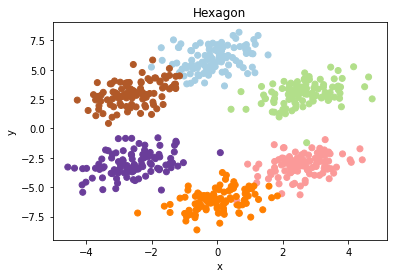

In [3]:
hexagon = pd.read_csv("data/hexagon.csv")
print(hexagon.head())
plt.scatter(hexagon.x, hexagon.y, c=hexagon.c, cmap='Paired')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Hexagon')
plt.show()

In [4]:
koh.weights.shape

NameError: name 'koh' is not defined

## Gauss
- width=1 (domyślna wartość)

Random weights


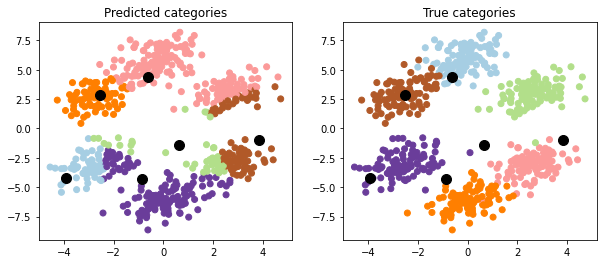

Number of epoch:  0


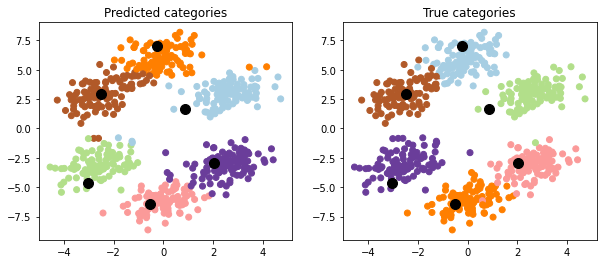

Number of epoch:  2


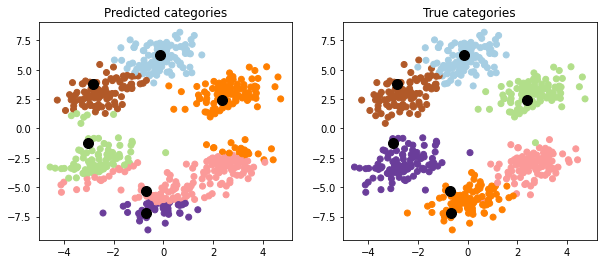

Number of epoch:  4


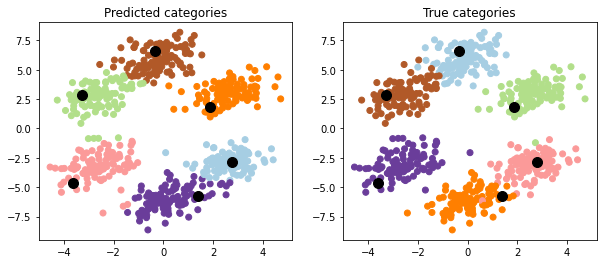

Number of epoch:  6


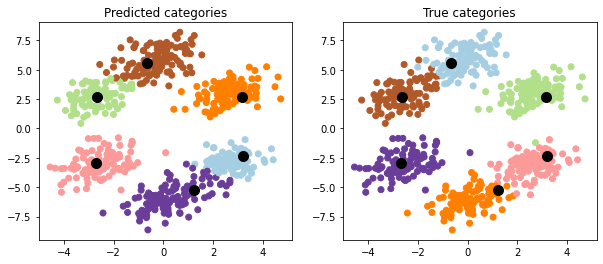

Number of epoch:  8


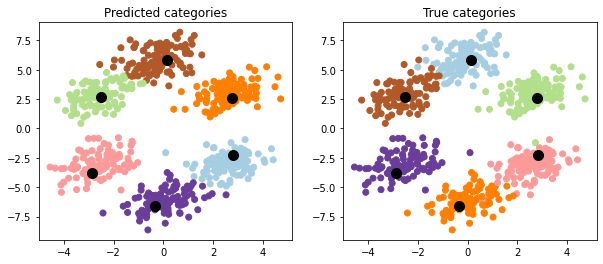

Number of epoch:  10


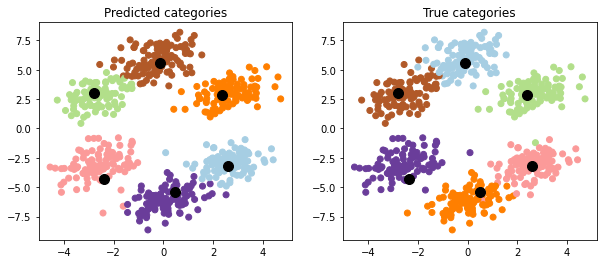

In [5]:
# k - wymiar danych (liczba kolumn)
koh = Koh(k=2, N=3, M=2, theta_fun='gauss')
koh.train(df=np.array(hexagon), n_epochs=11, graph_period=2)

Bardzo dobre odwzorowanie klastrów.

- width=0.1

Random weights


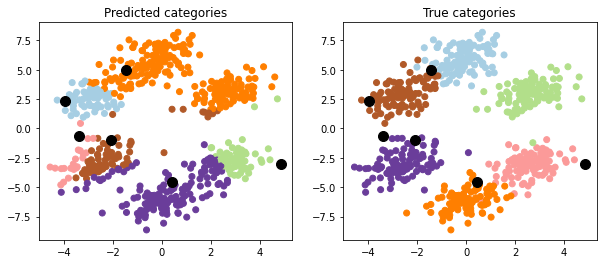

Number of epoch:  0


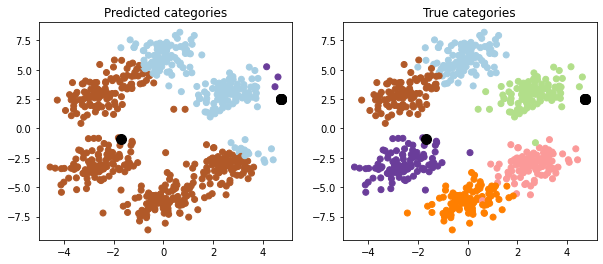

Number of epoch:  1


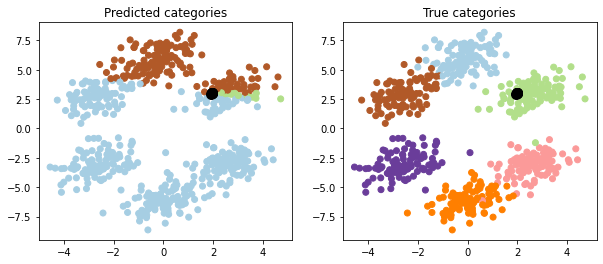

In [107]:
koh = Koh(k=2, N=3, M=2, theta_fun='gauss')
koh.train(df=np.array(hexagon), n_epochs=2, graph_period=1, width=0.1)

Neurony praktycznie od pierwszej epoki nałożyły się na siebie.

- width=0.5

Random weights


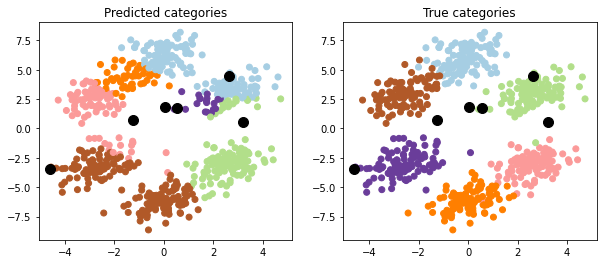

Number of epoch:  0


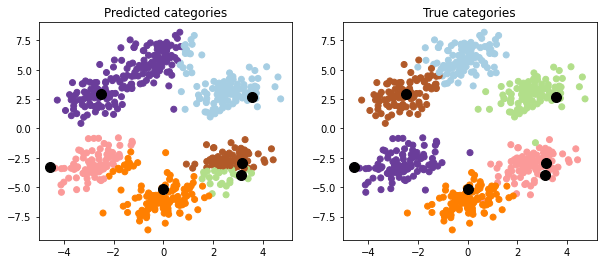

Number of epoch:  2


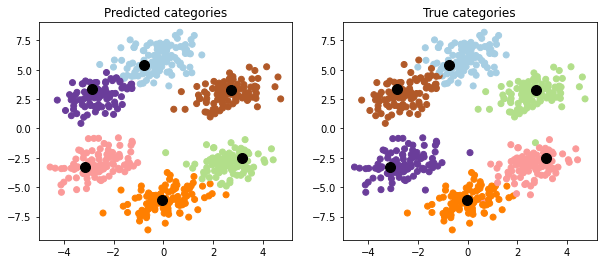

Number of epoch:  4


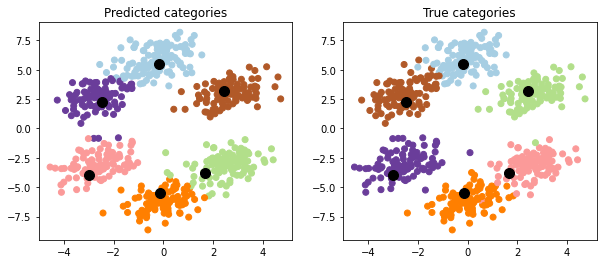

Number of epoch:  6


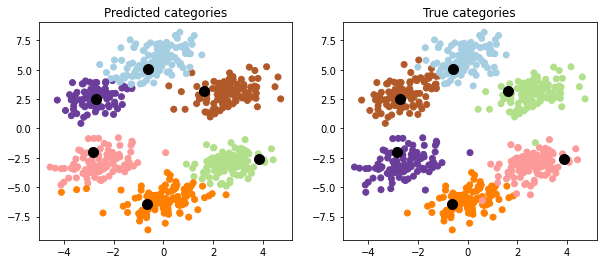

Number of epoch:  8


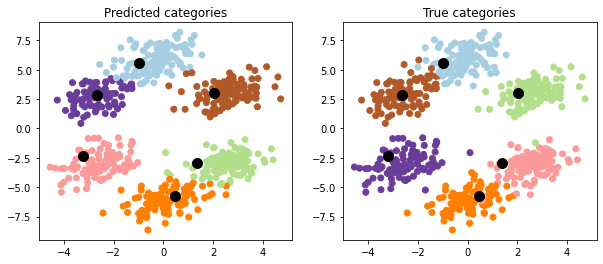

In [108]:
koh = Koh(k=2, N=3, M=2, theta_fun='gauss')
koh.train(df=np.array(hexagon), n_epochs=10, graph_period=2, width=0.5)

Neurony nie pokryły się.

Random weights


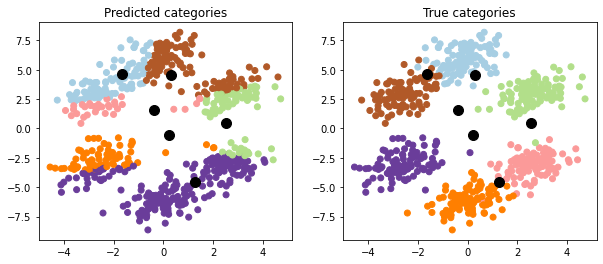

Number of epoch:  0


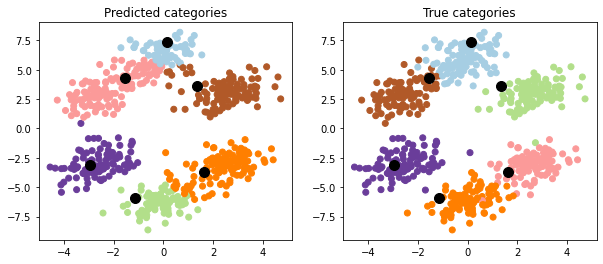

Number of epoch:  2


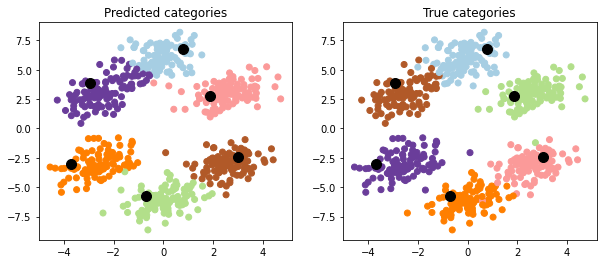

Number of epoch:  4


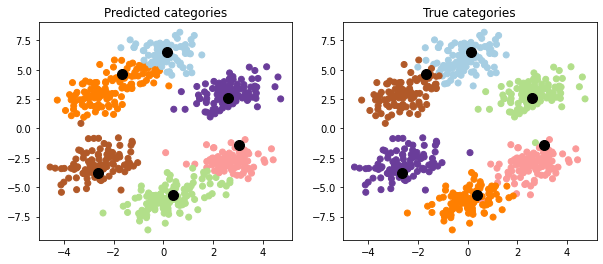

Number of epoch:  6


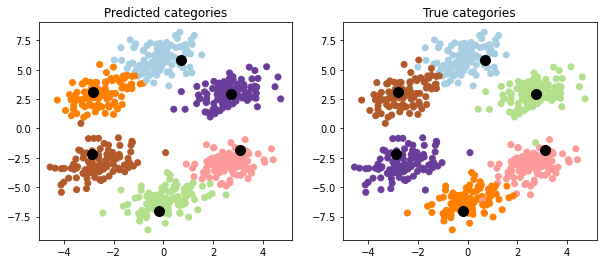

Number of epoch:  8


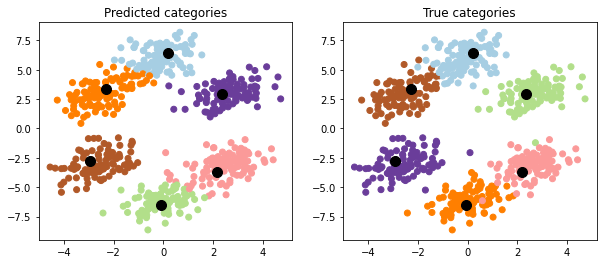

In [109]:
koh = Koh(k=2, N=3, M=2, theta_fun='gauss')
koh.train(df=np.array(hexagon), n_epochs=10, graph_period=2, width=0.8)

### Początkowa liczba neuronów większa niż rzeczywista liczba klastrów

Random weights


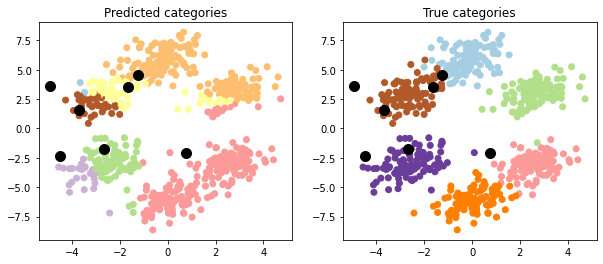

Number of epoch:  0


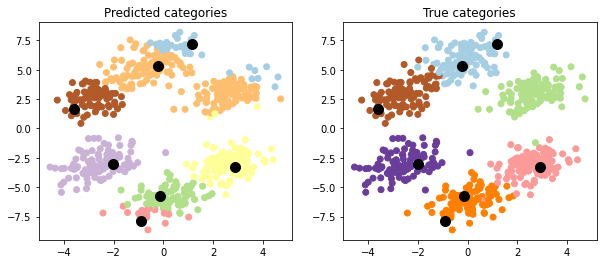

Number of epoch:  2000


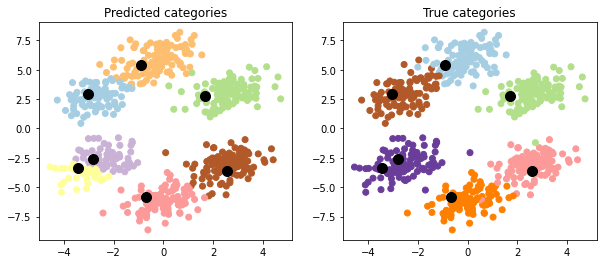

Number of epoch:  4000


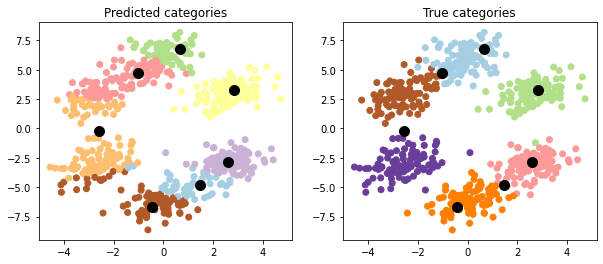

Number of epoch:  6000


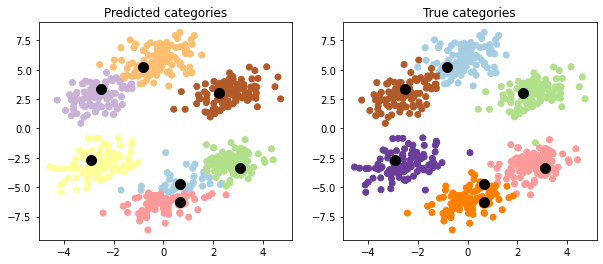

Number of epoch:  8000


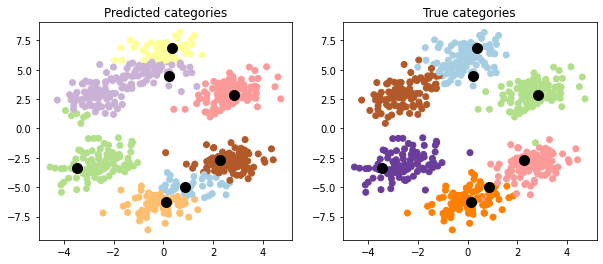

Number of epoch:  10000


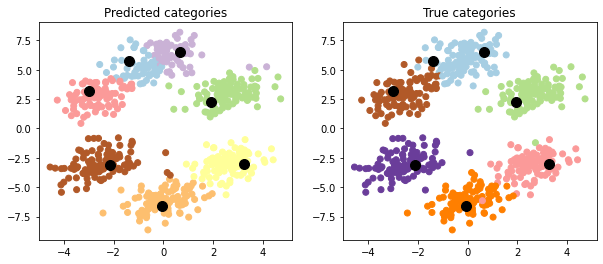

In [119]:
koh = Koh(k=2, N=7, M=1, theta_fun='gauss')
koh.train(df=np.array(hexagon), n_epochs=10001, graph_period=2000)

Dla 7 neuronów nie udało się dojść do właściwej liczby klastrów, tzn. 6. Zmniejszę więc szerokość sąsiedztwa z nadzieją, że 2 neurony nałożą się na siebie.

Random weights


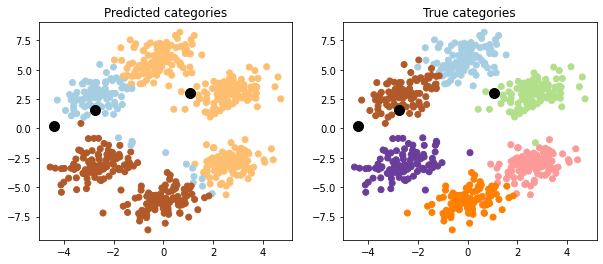

Number of epoch:  0


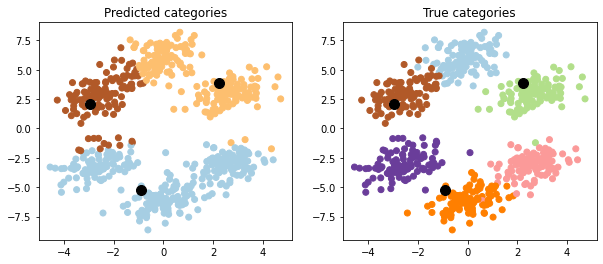

Number of epoch:  500


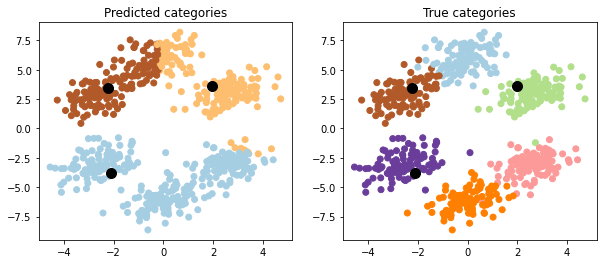

Number of epoch:  1000


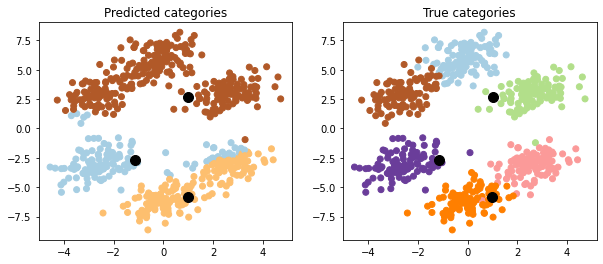

Number of epoch:  1500


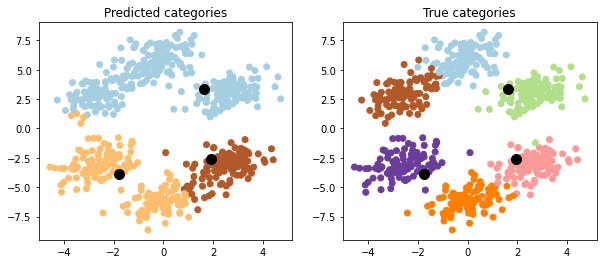

Number of epoch:  2000


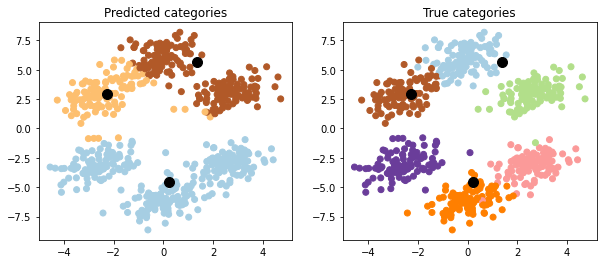

In [125]:
koh = Koh(k=2, N=3, M=1, theta_fun='gauss')
koh.train(df=np.array(hexagon), n_epochs=2001, graph_period=500, width=0.4)

Dla liczby mniejszej niż rzeczywistej liczby neuronów podział jest bardzo niestabilny.

## Mexico

Random weights


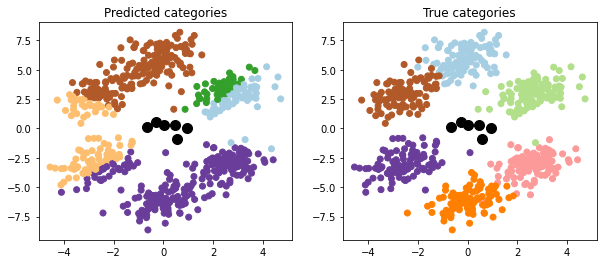

Number of epoch:  0


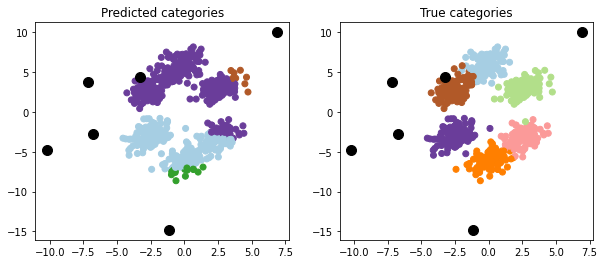

Number of epoch:  5


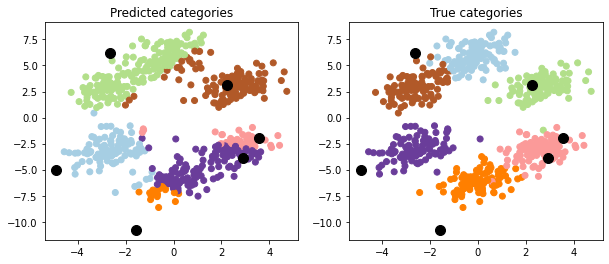

Number of epoch:  10


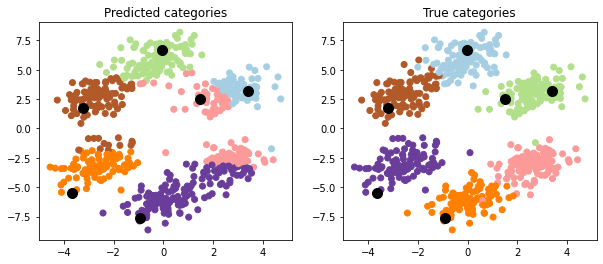

Number of epoch:  15


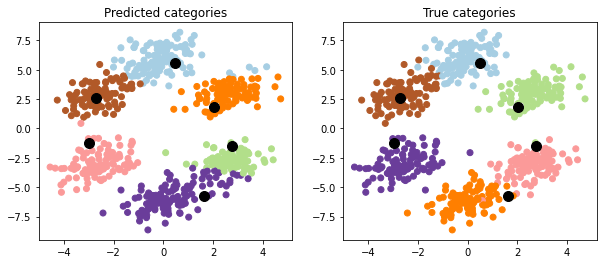

In [9]:
koh2 = Koh(k=2, N=3, M=2, theta_fun='mexico')
koh2.train(df=np.array(hexagon), n_epochs=20, graph_period=5)

Mexico też całkiem nieźle sobie radzi, aczkolwiek potrzebuje więcej epok na naukę.

## `Cube`

          x         y         z  c
0  0.187781  0.239537  0.382492  0
1 -1.308979 -0.143321 -0.966648  0
2 -0.987613  0.679918 -0.037552  0
3  0.924980  0.607235 -0.146856  0
4 -0.098663  0.004329 -0.588876  0


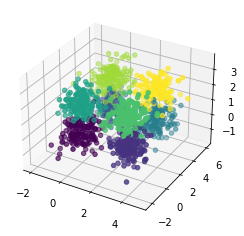

In [80]:
cube = pd.read_csv("data/cube.csv")
print(cube.head())

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cube.x, cube.y, cube.z, c=cube.c)
plt.show()

Random weights


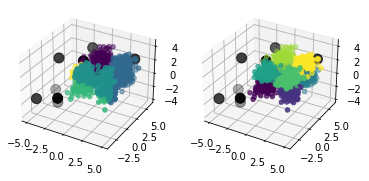

Number of epoch:  0


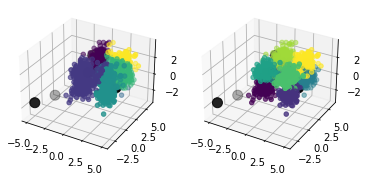

Number of epoch:  500


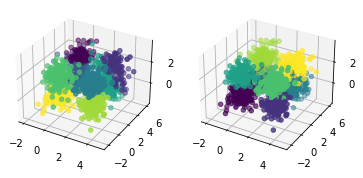

Number of epoch:  1000


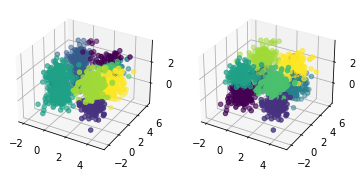

Number of epoch:  1500


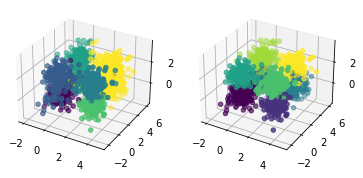

Number of epoch:  2000


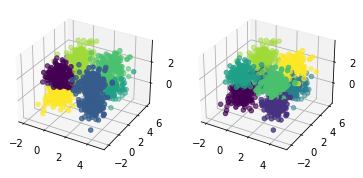

In [105]:
koh_c = Koh(k=3, N=4, M=2)
koh_c.train(df=np.array(cube), n_epochs=2001, graph_period=500, width=1)

Nieźle!